In [31]:
import pandas as pd

# Load the CSV file
file_path = r"B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\src\mahbub\finalDatasetWithUPDRSScore.csv"
data = pd.read_csv(file_path)

In [32]:
print(data.columns)

Index(['Patient ID', 'Visit Date', 'Area', 'Circularity', 'ConvexArea',
       'EquivDiameter', 'Extent', 'FilledArea', 'Kurtosis',
       'Major axis length', 'Mean', 'Minor axis length', 'PA_ratio',
       'Shannon_Entropy', 'Skewness', 'Solidity', 'Standard Deviation',
       'brightness', 'contrast', 'correlation', 'dissimilarity', 'energy',
       'gabor_energy', 'gabor_entropy', 'homogeneity', 'lbp_energy',
       'lbp_entropy', 'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'N

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input
# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")
# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_columns = "Disease_Severity"
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Visit Class)
data = pd.get_dummies(data, columns=['Disease_Severity'], drop_first=False)
import numpy as np

sequences = []
targets = []

grouped = data.groupby('Patient ID')

import numpy as np


def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets



# Get updated list of target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)
# Create sequences
sequences, targets = create_sequences(data, non_feature_columns,numerical_features,categorical_features, target_columns)
print(sequences.shape)
# Convert sequences and targets to numpy arrays
X = np.array(sequences)
print(X.shape)
y = np.array(targets)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)
# Define LSTM model for sequence of 4 visits per patient
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)  # Only one LSTM layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Train LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


# Evaluate LSTM model on training and testing sets
lstm_train_loss, lstm_train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)



print(f"LSTM - Train Loss: {lstm_train_loss}, Train Accuracy: {lstm_train_accuracy}")
print(f"LSTM - Test Loss: {lstm_test_loss}, Test Accuracy: {lstm_test_accuracy}")


(228, 4, 91)
(228, 4, 91)
(182, 4, 91) (46, 4, 91)
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2602 - loss: 1.7250
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4925 - loss: 1.4345 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4531 - loss: 1.3727 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5015 - loss: 1.3176 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5927 - loss: 1.1752 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 1.1725 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5320 - loss: 1.1526 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5217 - loss: 1.1237 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6138 - loss: 1.0374 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6499 - loss: 0.9686 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6608 - loss: 0.9317 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━

In [34]:
lstm_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[1.18419109e-02, 1.79231015e-03, 5.58800995e-02, 8.89431834e-01,
        2.50001680e-02, 1.60536878e-02],
       [1.20860641e-03, 5.60542801e-04, 1.62076410e-02, 5.55125356e-01,
        4.03958440e-01, 2.29394250e-02],
       [1.60954776e-03, 2.10358368e-04, 2.38125422e-03, 9.48689640e-01,
        2.98876781e-02, 1.72214657e-02],
       [1.56303167e-01, 2.89307744e-03, 8.11452150e-01, 2.70297583e-02,
        1.73307071e-03, 5.88748138e-04],
       [6.04018709e-03, 3.77238874e-04, 8.57709587e-01, 3.41693941e-03,
        6.54718727e-02, 6.69842660e-02],
       [5.00401892e-02, 1.74790609e-03, 9.40077007e-01, 6.42858911e-03,
        7.78422575e-04, 9.27892048e-04],
       [1.70079723e-03, 3.30207229e-04, 3.90849030e-03, 9.37252641e-01,
        5.51767973e-03, 5.12901470e-02],
       [1.89020458e-04, 5.17602777e-04, 2.83727376e-03, 1.95207652e-02,
        3.58347371e-02, 9.41100538e-01],
       [5.79824089e-04, 2.18991679e-03, 7.43767340e-03, 9.60015297e-01,
        1.12991249e-02, 

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2043 - loss: 2.1457  
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3500 - loss: 1.6506 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4717 - loss: 1.4793 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4657 - loss: 1.3398 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4597 - loss: 1.3886 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4667 - loss: 1.2633 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5161 - loss: 1.1133 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5888 - loss: 1.0917 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5768 - loss: 1.0768 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 1.0039 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6127 - loss: 0.9194 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7187 - loss: 0.8347 


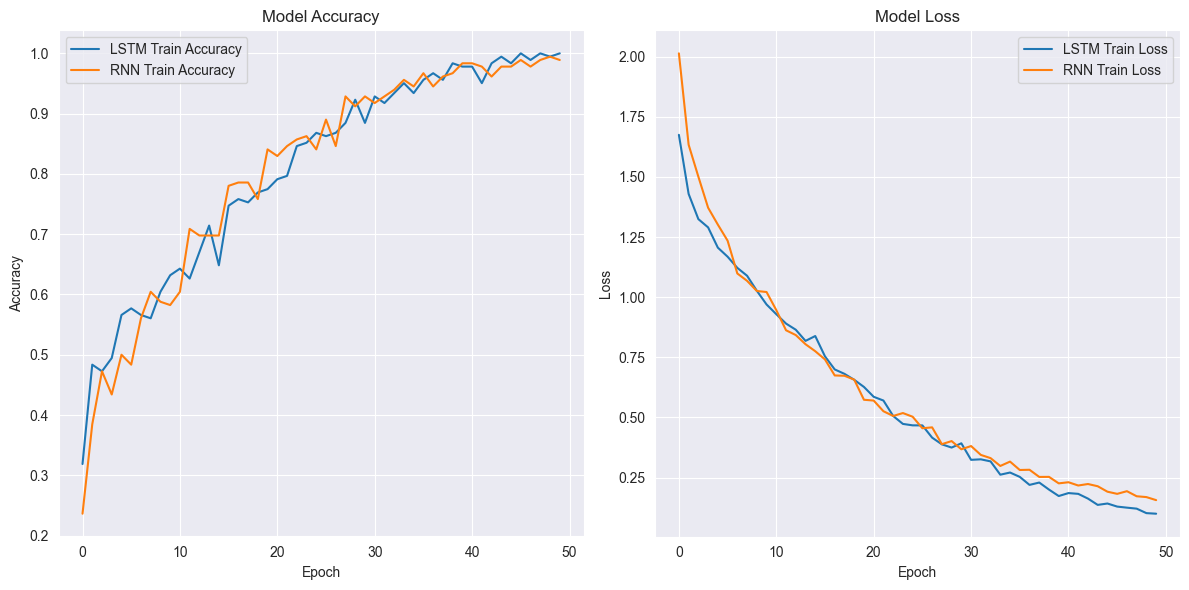

In [35]:
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train SimpleRNN model
rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate SimpleRNN model on training and testing sets
rnn_train_loss, rnn_train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
rnn_test_loss, rnn_test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)

print(f"SimpleRNN - Train Loss: {rnn_train_loss}, Train Accuracy: {rnn_train_accuracy}")
print(f"SimpleRNN - Test Loss: {rnn_test_loss}, Test Accuracy: {rnn_test_accuracy}")

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Train Loss')
plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create LSTM model
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 7
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train LSTM model
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")


Fold 1/7
Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2442 - loss: 1.6917
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4234 - loss: 1.4483 
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4664 - loss: 1.3610 
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4779 - loss: 1.2794 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4891 - loss: 1.2234 
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5127 - loss: 1.1916 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5128 - loss: 1.1386 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5655 - loss: 1.0992 
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6318 - loss: 1.0282 
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5811 - loss: 1.0342 
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5811 - loss: 1.0267 
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5751 - loss: 0

Fold 1/5
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0680 - loss: 1.9761      
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3696 - loss: 1.6009 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5192 - loss: 1.4281 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4592 - loss: 1.3933 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4534 - loss: 1.3717 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4800 - loss: 1.3359 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5197 - loss: 1.2663 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5087 - loss: 1.2105 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5478 - loss: 1.1693 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5615 - loss: 1.1237 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5860 - loss: 1.1069 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5681 - l

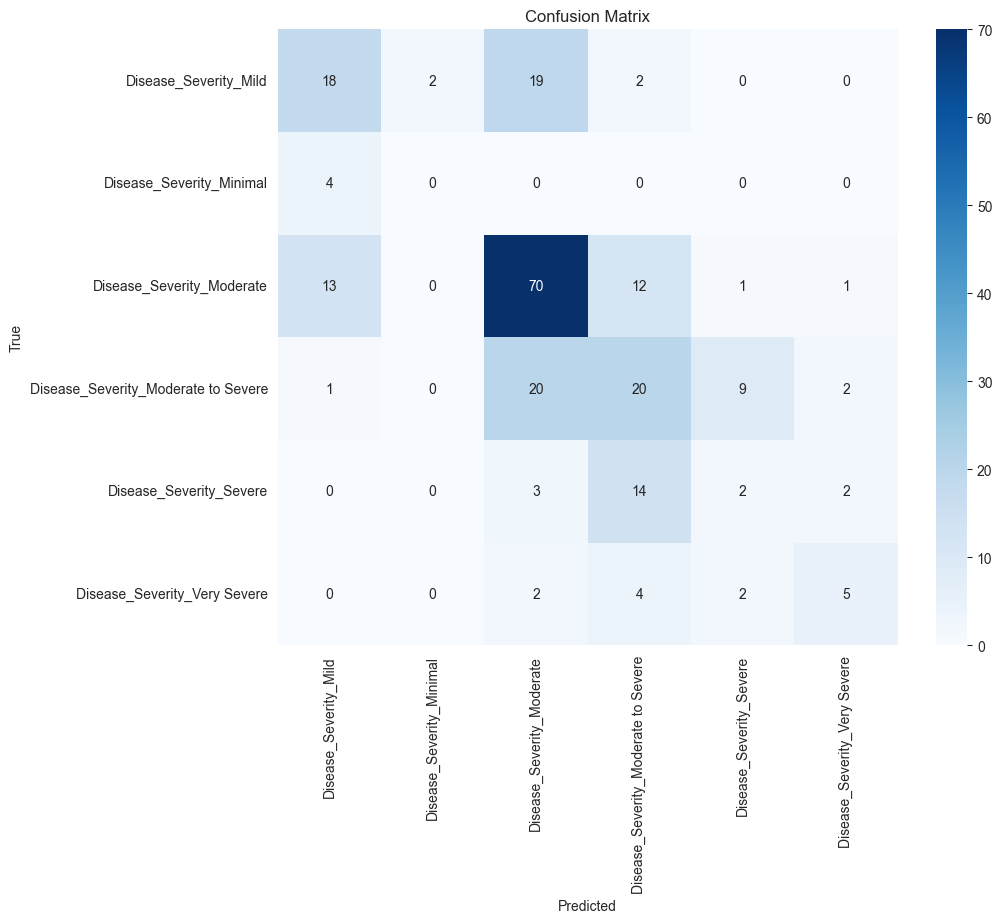

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create LSTM model
def create_lstm_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50)(inputs)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Initialize confusion matrix
cm = np.zeros((len(target_columns), len(target_columns)))

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train LSTM model
    lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = lstm_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)
    
    # Predictions for confusion matrix
    y_pred = lstm_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Update confusion matrix
    cm += confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(target_columns)))

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fold 1/5
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1729 - loss: 2.1512
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3041 - loss: 1.7019 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4657 - loss: 1.4916 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4586 - loss: 1.4315 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4435 - loss: 1.4342 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5043 - loss: 1.3859 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5199 - loss: 1.2336 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4925 - loss: 1.2118 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5194 - loss: 1.1595 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5259 - loss: 1.1523 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5290 - loss: 1.1199 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5900 - loss: 1

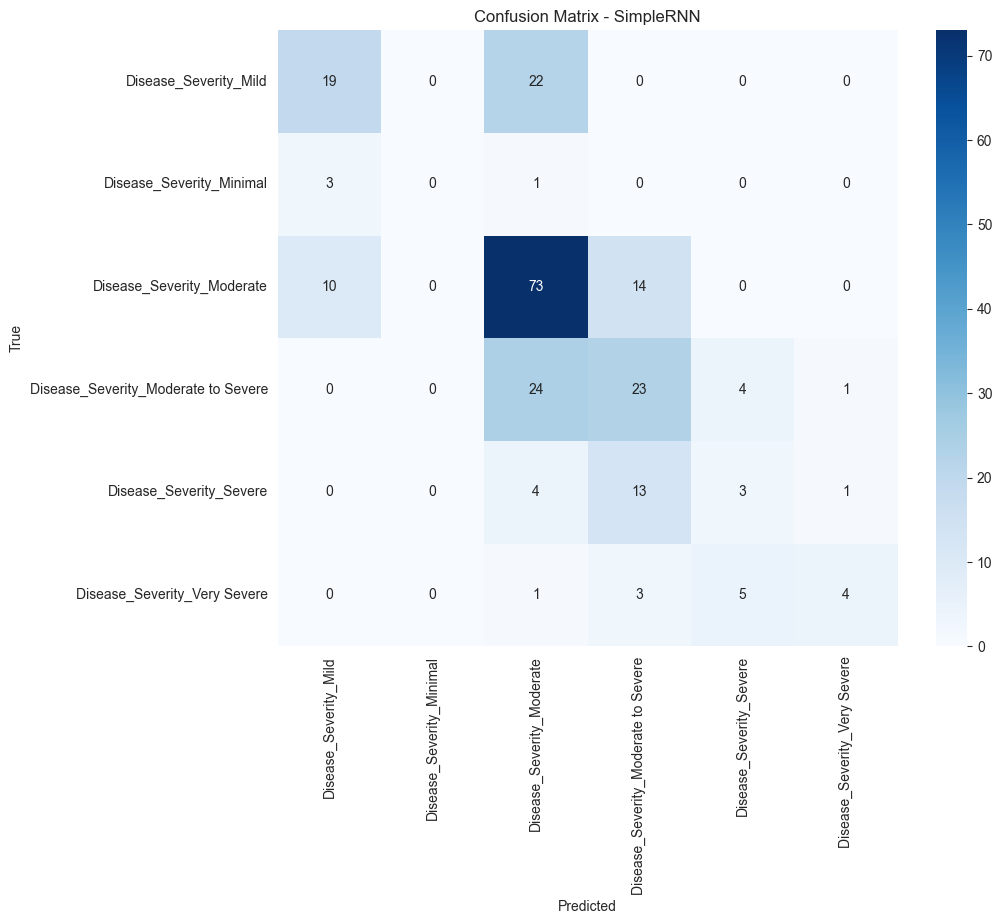

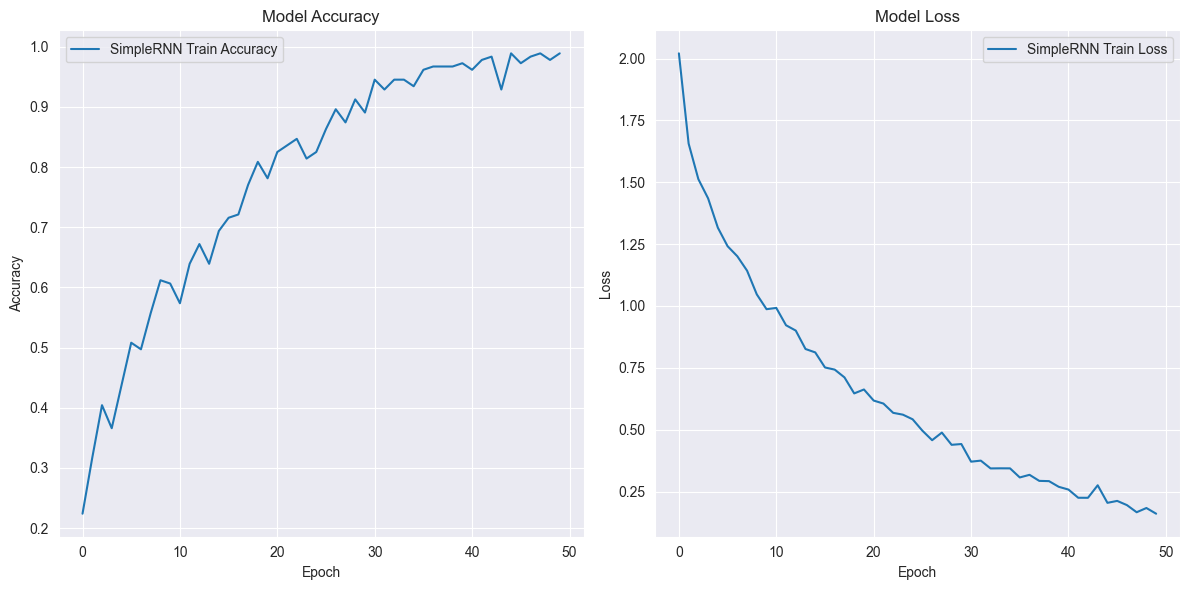

In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
        'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
       'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
       'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
       'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
       'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
       'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
       'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
       'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
       'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
       'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
       'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create SimpleRNN model
def create_rnn_model(input_shape, output_shape):
    inputs = Input(shape=input_shape)
    x = SimpleRNN(50)(inputs)  # Only one SimpleRNN layer needed since sequence length is fixed (4)
    x = Dropout(0.2)(x)
    outputs = Dense(output_shape, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create KFold cross-validation object
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store results
fold_train_losses = []
fold_train_accuracies = []
fold_test_losses = []
fold_test_accuracies = []

# Initialize confusion matrix
cm = np.zeros((len(target_columns), len(target_columns)))

# Perform KFold cross-validation
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {fold_index + 1}/{n_splits}")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Create and train SimpleRNN model
    rnn_model = create_rnn_model((X_train.shape[1], X_train.shape[2]), len(target_columns))
    rnn_history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # Evaluate model on training set
    train_loss, train_accuracy = rnn_model.evaluate(X_train, y_train, verbose=0)
    fold_train_losses.append(train_loss)
    fold_train_accuracies.append(train_accuracy)
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    
    # Evaluate model on testing set
    test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
    fold_test_losses.append(test_loss)
    fold_test_accuracies.append(test_accuracy)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    print("-" * 30)
    
    # Predictions for confusion matrix
    y_pred = rnn_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    # Update confusion matrix
    cm += confusion_matrix(y_true_classes, y_pred_classes, labels=np.arange(len(target_columns)))

# Print average results across all folds
print("Average Results Across Folds:")
print(f"Train Loss: {np.mean(fold_train_losses)}, Train Accuracy: {np.mean(fold_train_accuracies)}")
print(f"Test Loss: {np.mean(fold_test_losses)}, Test Accuracy: {np.mean(fold_test_accuracies)}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=target_columns, yticklabels=target_columns)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SimpleRNN')
plt.show()

# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='SimpleRNN Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='SimpleRNN Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Prepare data for HMM (assuming you have preprocessed your data)
hmm_data = data[numerical_features+categorical_features].values

# Normalize data if necessary (HMMs are sensitive to scale)
# scaler = StandardScaler()
# hmm_data_scaled = scaler.fit_transform(hmm_data)

# Initialize HMM model
model = hmm.GaussianHMM(n_components=6, covariance_type="diag", n_iter=100)

# Fit the model to your data
model.fit(hmm_data)

# Predict the hidden states for the data
hidden_states = model.predict(hmm_data)

# Print the most likely sequence of hidden states
print("Most likely sequence of hidden states:")
print(hidden_states)


Most likely sequence of hidden states:
[4 2 2 2 4 2 2 2 1 2 2 2 4 2 0 2 4 4 4 4 1 2 2 2 4 2 2 2 4 2 2 3 5 0 0 0 2
 3 2 2 4 4 1 4 4 4 4 4 1 1 5 4 1 0 2 2 5 1 4 1 2 2 2 2 5 0 0 0 1 4 1 4 2 4
 2 4 4 4 4 1 4 4 1 5 5 0 0 0 4 0 0 0 4 1 1 2 1 5 3 3 5 3 3 3 1 4 1 0 0 5 1
 0 4 0 1 4 1 1 1 2 1 1 4 1 1 1 1 5 1 1 1 1 4 5 4 1 5 0 2 0 1 1 1 1 1 1 1 1
 4 4 2 1 1 1 5 0 4 1 1 1 5 5 5 1 1 5 5 5 5 5 5 5 2 2 3 3 2 5 2 5 1 1 1 4 2
 3 3 0 5 2 0 0 1 1 0 0 4 0 4 5 1 4 1 4 5 5 2 5 1 1 0 0 1 1 1 1 1 2 2 2 1 2
 4 5 4 2 4 1 4 4 1 4 4 4 2 1 4 1 5 0 1 1 1 1 2 1 1 1 5 3 3 3 5 5 5 1 2 1 1
 5 1 1 4 4 0 2 0 2 1 4 1 0 2 2 2 1 4 4 4 4 2 2 2 1 1 1 1 2 4 4 4 2 4 1 4 4
 4 4 4 4 4 4 4 4 4 4 4 1 4 4 2 2 4 4 1 1 1 4 1 4 2 1 4 2 4 4 0 0 0 3 0 3 2
 2 4 4 3 0 0 3 4 1 4 4 4 2 2 2 4 4 2 4 4 1 1 1 1 1 1 1 4 1 4 1 1 5 1 5 1 4
 4 0 4 3 1 1 0 4 2 0 4 4 4 4 1 1 1 1 4 1 4 4 4 4 4 2 4 4 4 3 4 4 4 4 4 4 2
 3 4 4 1 4 1 2 1 2 4 1 4 1 1 1 1 5 1 1 2 1 5 2 2 3 1 1 3 3 4 4 4 4 2 0 2 2
 4 4 1 1 2 1 1 2 2 1 2 3 1 1 4 1 1 4 1 5 1 1 4 2 4 0 3 0 4 4 

In [46]:
data['Predicted_State'] = hidden_states

# Optionally, you might want to convert the predicted states to integer if they are stored as floats
data['Predicted_State'] = data['Predicted_State'].astype(int)

In [47]:
data

,Patient ID,Visit Date,Area,Circularity,ConvexArea,EquivDiameter,Extent,FilledArea,Kurtosis,Major axis length,...,DATSCAN_CAUDATE_R,DATSCAN_CAUDATE_L,DATSCAN_PUTAMEN_R,DATSCAN_PUTAMEN_L,DATSCAN_PUTAMEN_R_ANT,DATSCAN_PUTAMEN_L_ANT,UPDRS_SCORE,Disease_Severity,Visit,Predicted_State
0,3010,2011-07,389.666667,0.347044,537.333333,21.855180,0.552101,393.333333,124.787788,27.661910,...,2.86,3.65,0.45,1.24,1.50,2.35,41.0,Moderate,V1,4
1,3010,2012-06,1242.000000,0.232069,1594.333333,39.709426,0.603968,1248.000000,52.422599,44.351253,...,1.93,2.60,0.53,0.78,1.03,1.61,58.0,Moderate to Severe,V2,2
2,3010,2013-07,887.000000,0.521797,1025.000000,33.604811,0.747054,888.333333,78.186385,36.053962,...,1.60,2.50,0.30,0.74,0.85,1.43,67.0,Severe,V3,2
3,3010,2015-06,737.333333,0.175688,922.000000,25.498446,0.560028,739.666667,63.755847,30.316400,...,1.51,1.92,0.44,0.54,0.76,1.02,47.0,Moderate,V4,2
4,3012,2011-10,862.333333,0.378363,1050.333333,33.124654,0.613324,863.333333,70.920120,39.665361,...,2.09,2.05,0.36,0.71,1.10,0.98,48.0,Moderate to Severe,V1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,137450,2024-03,670.333333,0.119386,1239.000000,28.865941,0.343458,671.666667,50.534147,45.143475,...,2.05,2.01,0.45,0.53,0.90,0.94,44.0,Moderate,V4,0
908,142004,2022-02,975.666667,0.441369,1238.000000,35.225654,0.593963,977.333333,60.710955,42.299448,...,2.43,2.45,0.73,1.33,1.31,1.77,68.0,Severe,V1,2
909,142004,2022-11,1286.333333,0.110355,2265.666667,39.889480,0.396733,1291.000000,66.326636,71.105530,...,1.46,2.14,0.48,0.96,0.88,1.50,39.0,Moderate,V2,2
910,142004,2023-04,1755.333333,0.305589,2503.666667,46.703287,0.621659,1764.333333,51.393542,93.088745,...,1.80,2.16,0.59,1.07,1.05,1.79,27.0,Mild,V3,1


In [52]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load and preprocess your dataset (as previously defined)
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# One-hot encode the target column
encoder = OneHotEncoder()
encoded_targets = encoder.fit_transform(data[[target_column]]).toarray()

# Preprocess numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Prepare sequences for LSTM
def create_sequences(data, numerical_features, categorical_features):
    sequences = []
    targets = []

    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Prepare numerical and categorical data
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)

        # Prepare sequences (assuming fixed number of visits per patient)
        if num_visits >= 4:
            sequences.append(patient_data[-4:])  # Last 4 visits
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)

        # Target state (last visit's disease severity)
        target = encoded_targets[group.index[-1]]  # One-hot encoded target
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Create sequences for LSTM
sequences, targets = create_sequences(data, numerical_features, categorical_features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Define and train LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(targets.shape[1], activation='softmax')  # Adjust units for one-hot encoded targets
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Extract LSTM outputs as observations for HMM
lstm_outputs = model.predict(X_train)  # Assuming X_train here, adjust as necessary

# Train HMM on LSTM outputs
hmm_model = GaussianHMM(n_components=targets.shape[1], covariance_type="diag", n_iter=1000)
hmm_model.fit(lstm_outputs)

# Predict with HMM
predicted_states = hmm_model.predict(lstm_outputs)

# Evaluate HMM accuracy or use for further predictions


Epoch 1/50


B:\Projects\PycharmProjects\PPMI_Research_on_Parkinson's\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2273 - loss: 1.8031
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3892 - loss: 1.4605 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4596 - loss: 1.4429 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4918 - loss: 1.3623 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4570 - loss: 1.3702 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4581 - loss: 1.3151 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4877 - loss: 1.2147 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5102 - loss: 1.1800 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5366 - loss: 1.2104 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5760 - loss: 1.0946 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5430 - loss: 1.0614 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6002 - loss: 1.0523 
Epoch 13/50
6

In [53]:
print(predicted_states)

[4 0 0 0 0 5 4 0 0 2 0 0 5 5 0 0 0 2 4 5 0 0 2 0 0 0 0 3 0 5 5 2 2 0 0 5 5
 5 2 5 5 0 2 1 1 5 0 2 0 2 0 5 0 0 5 0 5 5 0 0 0 2 5 0 5 0 0 2 0 3 0 5 0 0
 5 0 5 0 4 0 0 5 0 3 2 5 3 5 2 0 0 5 5 5 0 1 5 2 0 2 0 0 0 3 4 5 3 4 5 4 0
 0 0 0 2 0 5 5 3 4 4 2 0 0 3 5 3 4 0 0 2 2 0 0 0 0 2 0 0 5 3 2 0 0 0 0 2 5
 0 5 0 5 5 0 5 5 0 5 0 4 4 0 0 0 0 5 4 5 0 2 0 0 5 0 2 5 0 2 0 1 0 0]


In [58]:
lstm_outputs

array([[7.21748685e-04, 1.61245686e-03, 4.35705632e-02, 1.06268011e-01,
        8.02417397e-01, 4.54098284e-02],
       [1.63289066e-02, 6.59066194e-04, 9.68578458e-01, 1.39380544e-02,
        4.16721596e-04, 7.88064717e-05],
       [4.34790133e-03, 2.89928634e-04, 9.85971868e-01, 6.36972580e-03,
        2.99440115e-03, 2.61590067e-05],
       ...,
       [6.72237650e-02, 8.91368568e-01, 3.18950675e-02, 2.16503814e-03,
        1.94924907e-03, 5.39834471e-03],
       [8.49385038e-02, 1.97060201e-02, 7.76153564e-01, 1.16792746e-01,
        1.16451853e-03, 1.24465546e-03],
       [2.75530340e-03, 2.18085523e-04, 9.90311027e-01, 4.84914705e-03,
        1.83790550e-03, 2.84786074e-05]], dtype=float32)

In [60]:
# Group by 'Disease_Severity' and count rows
grouped_data = data.groupby('Disease_Severity').count()

# Print the grouped data
print(grouped_data)


                    Patient ID  Visit Date  Area  Circularity  ConvexArea  \
Disease_Severity                                                            
Mild                       281         281   281          281         281   
Minimal                     53          53    53           53          53   
Moderate                   346         346   346          346         346   
Moderate to Severe         155         155   155          155         155   
Severe                      58          58    58           58          58   
Very Severe                 19          19    19           19          19   

                    EquivDiameter  Extent  FilledArea  Kurtosis  \
Disease_Severity                                                  
Mild                          281     281         281       281   
Minimal                        53      53          53        53   
Moderate                      346     346         346       346   
Moderate to Severe            155     155       